<a href="https://colab.research.google.com/github/chaitrika31/AI-MV/blob/main/AI_%26_MV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import shutil
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/archive.zip"


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# path to our dataset in Google Drive
data_dir = "/content/drive/MyDrive/garbage_dataset"

# image transforms for training (with augmentation) and for validation/testing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),           # resize images to 224x224
    transforms.RandomHorizontalFlip(),       # flip images horizontally
    transforms.RandomRotation(15),           # rotate images randomly
    transforms.ToTensor(),                   # convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # normalize using ImageNet mean/std
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),           # just resize for val/test
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# load the dataset from folders
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/test", transform=val_test_transforms)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# check class names and counts
class_names = train_dataset.classes
print("Classes:", class_names)
print("Train images:", len(train_dataset))
print("Validation images:", len(val_dataset))
print("Test images:", len(test_dataset))


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train images: 630
Validation images: 132
Test images: 138



TRAIN SET:
  cardboard: 105 images
  glass: 105 images
  metal: 105 images
  paper: 105 images
  plastic: 105 images
  trash: 105 images

VAL SET:
  cardboard: 22 images
  glass: 22 images
  metal: 22 images
  paper: 22 images
  plastic: 22 images
  trash: 22 images

TEST SET:
  cardboard: 23 images
  glass: 23 images
  metal: 23 images
  paper: 23 images
  plastic: 23 images
  trash: 23 images


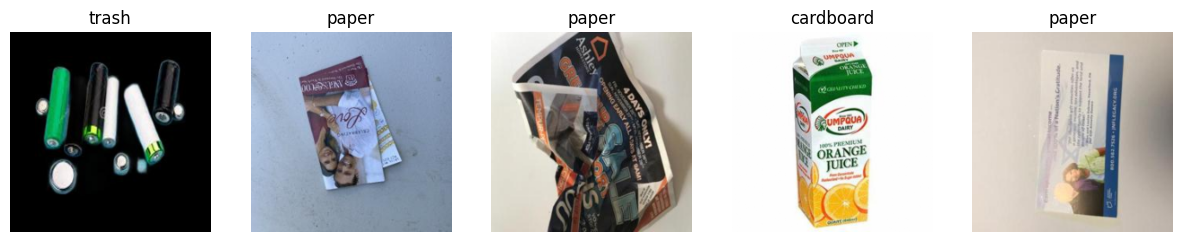


Original image sizes:
  metal - (256, 256)
  trash - (256, 256)
  cardboard - (256, 256)


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms

# path to dataset in Google Drive
data_dir = "/content/drive/MyDrive/garbage_dataset"

# show number of samples per class (text output)
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()} SET:")
    split_path = os.path.join(data_dir, split)
    for cls in sorted(os.listdir(split_path)):
        count = len(os.listdir(os.path.join(split_path, cls)))
        print(f"  {cls}: {count} images")

# transforms just for displaying random samples (no normalization)
display_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# load dataset for random samples
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=display_transform)
class_names = train_dataset.classes

# show random samples from training set
plt.figure(figsize=(15, 6))
for i in range(5):
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]
    img = img.permute(1, 2, 0).numpy()
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis("off")
plt.show()

# show original image sizes for 3 random samples
print("\nOriginal image sizes:")
for _ in range(3):
    cls = random.choice(class_names)
    img_path = os.path.join(data_dir, "train", cls, random.choice(os.listdir(os.path.join(data_dir, "train", cls))))
    with Image.open(img_path) as img:
        print(f"  {cls} - {img.size}")


In [ ]:
# transforms for training (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# transforms for validation and test (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# load datasets with transforms
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/test", transform=val_test_transforms)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train samples: 630
Validation samples: 132
Test samples: 138


In [ ]:
import torch

# choose GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def train_model(model_name, train_loader, val_loader, num_classes=6, num_epochs=5, lr=0.001):
    # load pretrained model
    if model_name.lower() == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name.lower() == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError("Model not supported")

    model = model.to(device)

    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc_history, val_acc_history = [], []

    start_time = time.time()
    for epoch in range(num_epochs):
        print(f"\n[{model_name}] Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # training phase
        model.train()
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        train_acc_history.append(epoch_train_acc.item())

        # validation phase
        model.eval()
        val_running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        epoch_val_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_acc_history.append(epoch_val_acc.item())

        print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

    elapsed_time = time.time() - start_time
    print(f"\nTraining time for {model_name}: {elapsed_time:.2f} seconds")
    return model, train_acc_history, val_acc_history


In [ ]:
# train ResNet18
resnet_model, resnet_train_acc, resnet_val_acc = train_model("resnet18", train_loader, val_loader, num_classes=len(train_dataset.classes), num_epochs=5)

# train EfficientNet-B0
effnet_model, effnet_train_acc, effnet_val_acc = train_model("efficientnet_b0", train_loader, val_loader, num_classes=len(train_dataset.classes), num_epochs=5)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]



[resnet18] Epoch 1/5
--------------------
Train Acc: 0.4968 | Val Acc: 0.3106

[resnet18] Epoch 2/5
--------------------
Train Acc: 0.5857 | Val Acc: 0.3258

[resnet18] Epoch 3/5
--------------------
Train Acc: 0.6889 | Val Acc: 0.5379

[resnet18] Epoch 4/5
--------------------
Train Acc: 0.7365 | Val Acc: 0.5455

[resnet18] Epoch 5/5
--------------------
Train Acc: 0.8238 | Val Acc: 0.5985

Training time for resnet18: 146.60 seconds
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]



[efficientnet_b0] Epoch 1/5
--------------------
Train Acc: 0.6032 | Val Acc: 0.7803

[efficientnet_b0] Epoch 2/5
--------------------
Train Acc: 0.8190 | Val Acc: 0.7652

[efficientnet_b0] Epoch 3/5
--------------------
Train Acc: 0.8968 | Val Acc: 0.7348

[efficientnet_b0] Epoch 4/5
--------------------
Train Acc: 0.9413 | Val Acc: 0.8030

[efficientnet_b0] Epoch 5/5
--------------------
Train Acc: 0.9365 | Val Acc: 0.7727

Training time for efficientnet_b0: 23.54 seconds


In [ ]:
import torch
import numpy as np

# simple helper to get test accuracy
def test_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# evaluate both models on test set
resnet_test_acc = test_accuracy(resnet_model, test_loader, device)
effnet_test_acc = test_accuracy(effnet_model, test_loader, device)

print(f"ResNet18  Test Accuracy: {resnet_test_acc:.4f}")
print(f"EffNet-B0 Test Accuracy: {effnet_test_acc:.4f}")


ResNet18  Test Accuracy: 0.5942
EffNet-B0 Test Accuracy: 0.7971


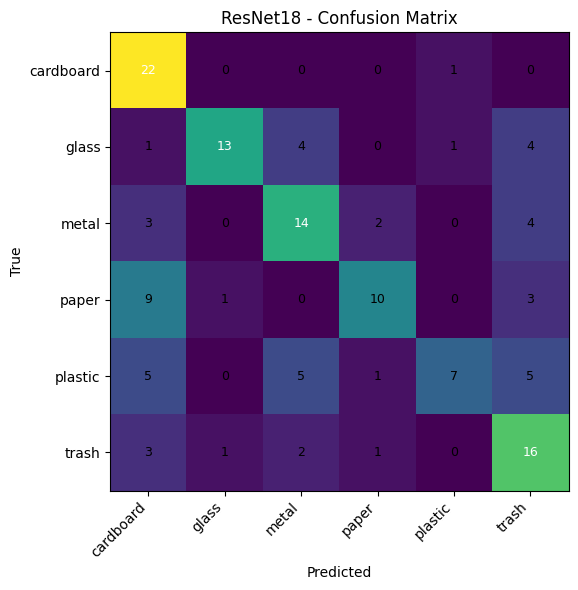

ResNet18 - Classification Report
              precision    recall  f1-score   support

   cardboard       0.51      0.96      0.67        23
       glass       0.87      0.57      0.68        23
       metal       0.56      0.61      0.58        23
       paper       0.71      0.43      0.54        23
     plastic       0.78      0.30      0.44        23
       trash       0.50      0.70      0.58        23

    accuracy                           0.59       138
   macro avg       0.66      0.59      0.58       138
weighted avg       0.66      0.59      0.58       138



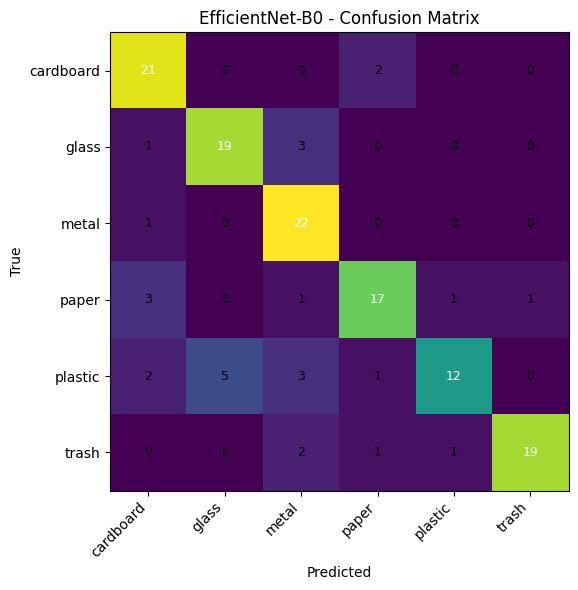

EfficientNet-B0 - Classification Report
              precision    recall  f1-score   support

   cardboard       0.75      0.91      0.82        23
       glass       0.79      0.83      0.81        23
       metal       0.71      0.96      0.81        23
       paper       0.81      0.74      0.77        23
     plastic       0.86      0.52      0.65        23
       trash       0.95      0.83      0.88        23

    accuracy                           0.80       138
   macro avg       0.81      0.80      0.79       138
weighted avg       0.81      0.80      0.79       138



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# get predictions and labels
def get_preds_labels(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# plot a confusion matrix with matplotlib (no seaborn)
def plot_cm(cm, classes, title):
    fig, ax = plt.subplots(figsize=(6.5, 6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # write counts in cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha="center", va="center", fontsize=9, color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout()
    plt.show()

# ResNet18 confusion matrix + report
resnet_preds, resnet_labels = get_preds_labels(resnet_model, test_loader, device)
resnet_cm = confusion_matrix(resnet_labels, resnet_preds)
plot_cm(resnet_cm, class_names, "ResNet18 - Confusion Matrix")
print("ResNet18 - Classification Report")
print(classification_report(resnet_labels, resnet_preds, target_names=class_names))

# EfficientNet-B0 confusion matrix + report
effnet_preds, effnet_labels = get_preds_labels(effnet_model, test_loader, device)
effnet_cm = confusion_matrix(effnet_labels, effnet_preds)
plot_cm(effnet_cm, class_names, "EfficientNet-B0 - Confusion Matrix")
print("EfficientNet-B0 - Classification Report")
print(classification_report(effnet_labels, effnet_preds, target_names=class_names))


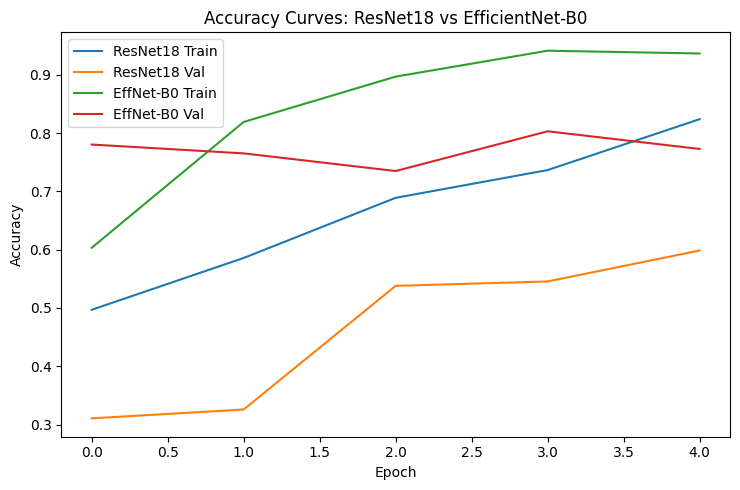

In [ ]:
import matplotlib.pyplot as plt

# training/validation accuracy curves
plt.figure(figsize=(7.5,5))
plt.plot(resnet_train_acc, label="ResNet18 Train")
plt.plot(resnet_val_acc,   label="ResNet18 Val")
plt.plot(effnet_train_acc, label="EffNet-B0 Train")
plt.plot(effnet_val_acc,   label="EffNet-B0 Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves: ResNet18 vs EfficientNet-B0")
plt.legend()
plt.tight_layout()
plt.show()


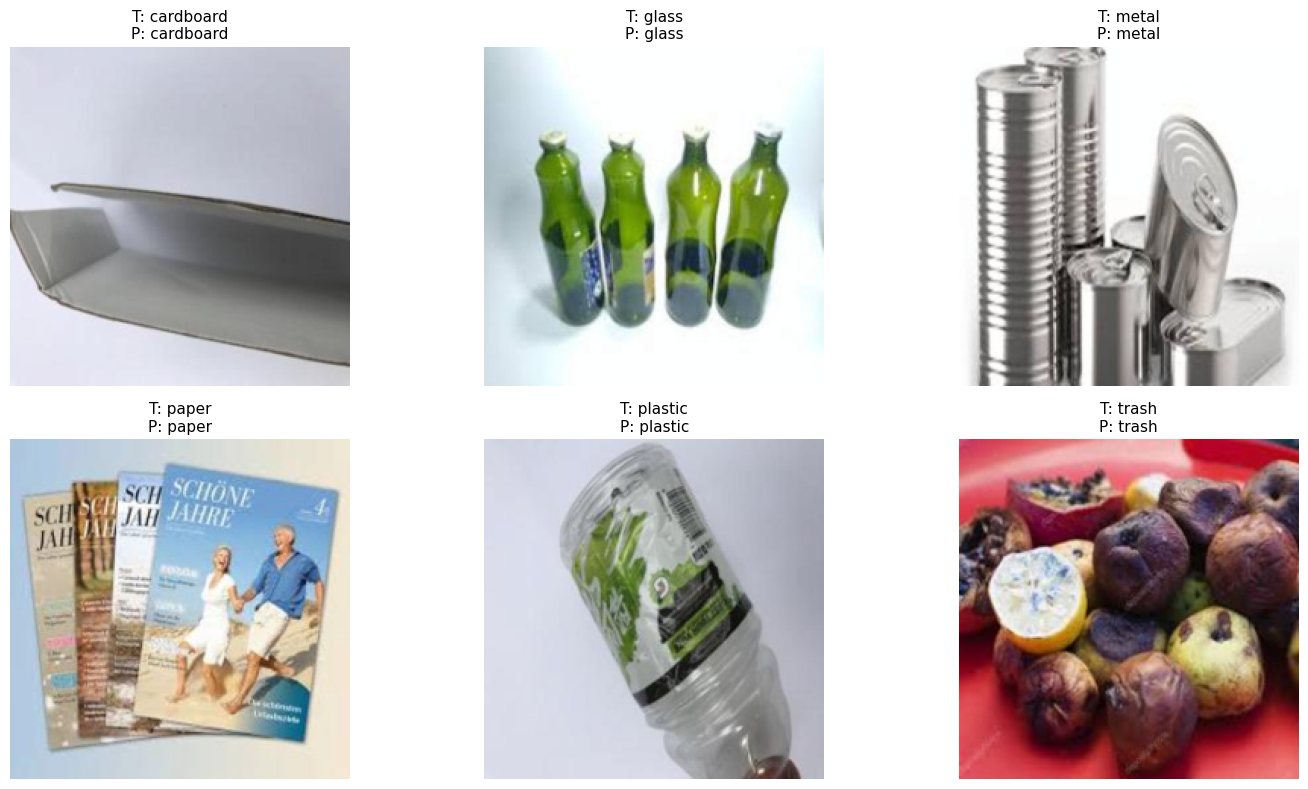

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# pick one model to visualize
model_to_show = effnet_model  # or resnet_model
model_to_show.eval()

# get full dataset (test set without batching)
test_images = []
test_labels = []
for imgs, labels in test_loader:
    test_images.extend(imgs)
    test_labels.extend(labels)

# randomly select images from different classes
selected_idx = []
for cls in range(len(class_names)):
    idx = random.choice([i for i, lbl in enumerate(test_labels) if lbl == cls])
    selected_idx.append(idx)

# plot one image per class
plt.figure(figsize=(15, 8))
for i, idx in enumerate(selected_idx):
    img = test_images[idx].unsqueeze(0).to(device)
    true_label = class_names[test_labels[idx].item()]
    with torch.no_grad():
        pred = model_to_show(img).argmax(1).item()
    pred_label = class_names[pred]

    # prepare image for display (unnormalize)
    img_disp = test_images[idx].permute(1, 2, 0).numpy()
    img_disp = img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_disp = np.clip(img_disp, 0, 1)

    plt.subplot(2, 3, i+1)
    plt.imshow(img_disp)
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=11)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch, random, numpy as np

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


In [ ]:
import time
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def train_model_full(model_name, train_loader, val_loader, test_loader,
                     num_classes=6, num_epochs=8, lr=1e-3, save_path=None, fine_tune=False):
    # ---- model ----
    if model_name.lower() == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        if not fine_tune:
            for p in model.parameters(): p.requires_grad = False
        in_f = model.fc.in_features
        model.fc = nn.Linear(in_f, num_classes)
        params = filter(lambda p: p.requires_grad, model.parameters())
    elif model_name.lower() == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        if not fine_tune:
            for p in model.parameters(): p.requires_grad = False
        in_f = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_f, num_classes)
        params = filter(lambda p: p.requires_grad, model.parameters())
    else:
        raise ValueError("Unsupported model")

    model = model.to(device)
    crit = nn.CrossEntropyLoss()
    opt = optim.Adam(params, lr=lr)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', patience=2, factor=0.5)


    hist = {"train_acc":[], "val_acc":[], "test_acc":[], "train_loss":[], "val_loss":[]}
    best_val = -1.0; best_state = None

    def eval_loop(loader):
        model.eval()
        correct, total, loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss_sum += crit(out, y).item() * x.size(0)
                pred = out.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        return correct/total, loss_sum/total

    t0 = time.time()
    for ep in range(num_epochs):
        # train
        model.train()
        correct, total, loss_sum = 0, 0, 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = crit(out, y)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        train_acc = correct/total
        train_loss = loss_sum/total

        # val + test each epoch
        val_acc, val_loss = eval_loop(val_loader)
        test_acc, _        = eval_loop(test_loader)

        hist["train_acc"].append(train_acc)
        hist["val_acc"].append(val_acc)
        hist["test_acc"].append(test_acc)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        sched.step(val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        print(f"[{model_name}] Ep {ep+1}/{num_epochs} | "
              f"Train {train_acc:.3f} Val {val_acc:.3f} Test {test_acc:.3f} | "
              f"Loss T:{train_loss:.3f} V:{val_loss:.3f}")

    # load best and optionally save
    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    if save_path:
        torch.save(model.state_dict(), save_path)
        print("Saved best weights to:", save_path)
    print(f"Done in {time.time()-t0:.1f}s, best val acc={best_val:.3f}")
    return model, hist


[resnet18] Ep 1/8 | Train 0.267 Val 0.409 Test 0.457 | Loss T:1.748 V:1.525
[resnet18] Ep 2/8 | Train 0.503 Val 0.553 Test 0.565 | Loss T:1.389 V:1.297
[resnet18] Ep 3/8 | Train 0.605 Val 0.538 Test 0.565 | Loss T:1.193 V:1.251
[resnet18] Ep 4/8 | Train 0.681 Val 0.667 Test 0.696 | Loss T:1.034 V:1.030
[resnet18] Ep 5/8 | Train 0.702 Val 0.720 Test 0.703 | Loss T:0.954 V:0.984
[resnet18] Ep 6/8 | Train 0.727 Val 0.682 Test 0.717 | Loss T:0.872 V:0.934
[resnet18] Ep 7/8 | Train 0.729 Val 0.712 Test 0.739 | Loss T:0.838 V:0.925
[resnet18] Ep 8/8 | Train 0.760 Val 0.742 Test 0.732 | Loss T:0.771 V:0.865
Saved best weights to: /content/drive/MyDrive/garbage_results/resnet18_best.pth
Done in 38.3s, best val acc=0.742
[efficientnet_b0] Ep 1/8 | Train 0.348 Val 0.644 Test 0.623 | Loss T:1.661 V:1.390
[efficientnet_b0] Ep 2/8 | Train 0.657 Val 0.674 Test 0.659 | Loss T:1.270 V:1.184
[efficientnet_b0] Ep 3/8 | Train 0.735 Val 0.720 Test 0.667 | Loss T:1.044 V:1.051
[efficientnet_b0] Ep 4/8 | Tr

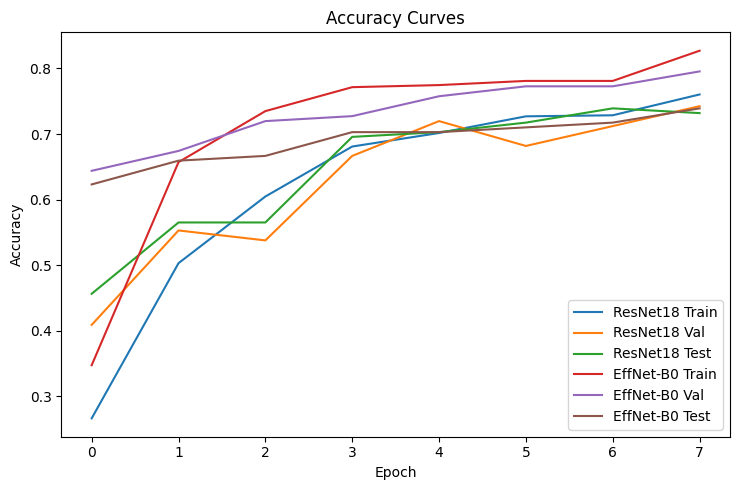

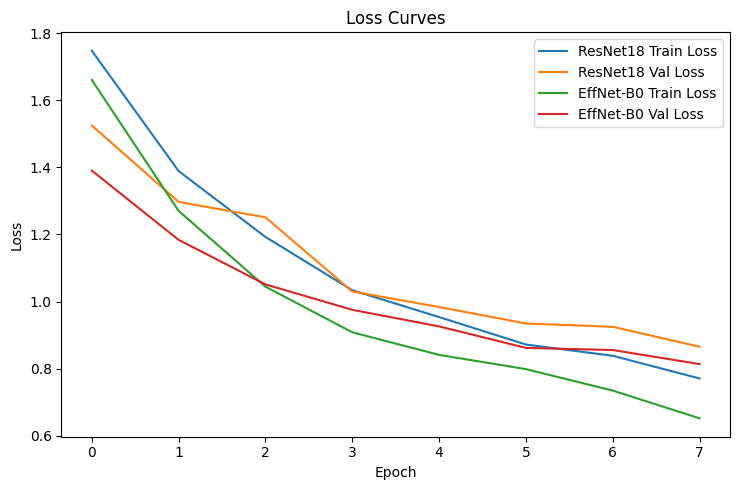

Saved figures and weights to: /content/drive/MyDrive/garbage_results


In [ ]:
import os, matplotlib.pyplot as plt

# paths to save (change if you like)
out_dir = "/content/drive/MyDrive/garbage_results"
os.makedirs(out_dir, exist_ok=True)

# train
resnet_model, res_hist = train_model_full(
    "resnet18", train_loader, val_loader, test_loader,
    num_classes=len(train_dataset.classes), num_epochs=8,
    lr=1e-3, save_path=f"{out_dir}/resnet18_best.pth", fine_tune=False
)
effnet_model, eff_hist = train_model_full(
    "efficientnet_b0", train_loader, val_loader, test_loader,
    num_classes=len(train_dataset.classes), num_epochs=8,
    lr=1e-3, save_path=f"{out_dir}/effnet_b0_best.pth", fine_tune=False
)

# plots: accuracy (train/val/test)
plt.figure(figsize=(7.5,5))
plt.plot(res_hist["train_acc"], label="ResNet18 Train")
plt.plot(res_hist["val_acc"],   label="ResNet18 Val")
plt.plot(res_hist["test_acc"],  label="ResNet18 Test")
plt.plot(eff_hist["train_acc"], label="EffNet-B0 Train")
plt.plot(eff_hist["val_acc"],   label="EffNet-B0 Val")
plt.plot(eff_hist["test_acc"],  label="EffNet-B0 Test")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves")
plt.legend(); plt.tight_layout()
plt.savefig(f"{out_dir}/accuracy_curves.png", dpi=150); plt.show()

# plots: loss (train/val)
plt.figure(figsize=(7.5,5))
plt.plot(res_hist["train_loss"], label="ResNet18 Train Loss")
plt.plot(res_hist["val_loss"],   label="ResNet18 Val Loss")
plt.plot(eff_hist["train_loss"], label="EffNet-B0 Train Loss")
plt.plot(eff_hist["val_loss"],   label="EffNet-B0 Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves")
plt.legend(); plt.tight_layout()
plt.savefig(f"{out_dir}/loss_curves.png", dpi=150); plt.show()

print("Saved figures and weights to:", out_dir)
